In [1]:
!pip install -q librosa numpy pandas scikit-learn matplotlib tqdm

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/train.csv')
AUDIO_PATH='/kaggle/input/shl-hiring-assessment/Dataset/audios/train'

In [5]:
def extract_features(file_path,sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y)
    
    features = {
        'mfcc_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
        'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1),
        'spectral_contrast_mean': np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1),
        'zcr_mean': np.mean(librosa.feature.zero_crossing_rate(y)[0]),
        'rmse_mean': np.mean(librosa.feature.rms(y=y)[0])
    }

    feature_vector = np.concatenate([
        features['mfcc_mean'],
        features['chroma_stft_mean'],
        features['spectral_contrast_mean'],
        [features['zcr_mean'], features['rmse_mean']]
    ])
    return feature_vector

In [6]:
X, y = [], []
for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    features = extract_features(file_path)
    X.append(features)
    y.append(row['label'])

100%|██████████| 444/444 [08:34<00:00,  1.16s/it]


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse:.4f}')

Validation RMSE: 0.9403


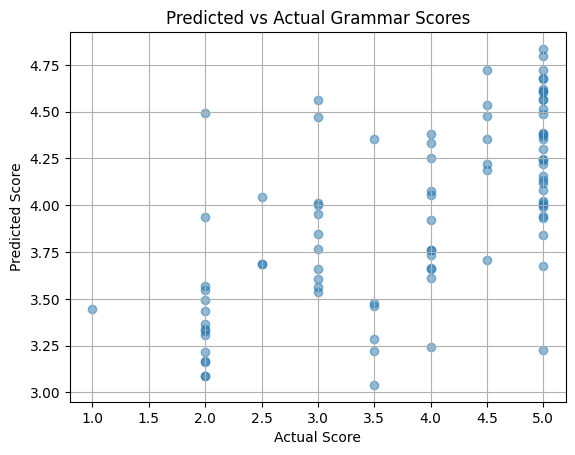

In [11]:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Grammar Scores")
plt.grid(True)
plt.show()

In [12]:
test_df=pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/test.csv')
test_audio_path='/kaggle/input/shl-hiring-assessment/Dataset/audios/test'

In [14]:
X_test = []
for fname in tqdm(test_df['filename']):
    fpath = os.path.join(test_audio_path, fname)
    X_test.append(extract_features(fpath))

100%|██████████| 204/204 [03:39<00:00,  1.08s/it]


In [15]:
X_test = np.array(X_test)
y_test_pred = model.predict(X_test)

In [16]:
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': y_test_pred
})
submission.to_csv('submission_1.1.csv', index=False)